In [18]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [19]:
df = pd.read_csv('./data/iris.csv')

# extract only two classes 'Iris-setosa' and 'Iris-versicolor'. Drop 'Iris-virginica'
df = df[df['species'] != 'Iris-virginica']

# make the labels 1 and 0
df['species'].replace(["Iris-setosa","Iris-versicolor"], [1,0], inplace=True)

# generate X and y tensors, adding the ``1'' feature for the bias
N, D = df.shape # N=100, D=5
X = torch.tensor(df.iloc[:, 0:D-1].values, dtype=torch.float32)
X = torch.cat((torch.ones((N,1)), X), dim=1)
y = torch.tensor(df.iloc[:, D-1].values, dtype=torch.float32)


In [20]:
# difine the cross entropy loss function
def cross_entropy(y_pred, y):
    return -torch.mean(y * torch.log(y_pred) + (1 - y) * torch.log(1 - y_pred))

# The reason we use cross entropy is that it is the negative log likelihood of the Bernoulli distribution
# and it is convex. Using the least squares loss function for logistic regression is not a good
# idea because it is not convex and can lead to multiple local minima.


In [21]:
# divide the data into training and test sets randomly 80 and 20 percent
# use scikit-learn or do it manually

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

Training set size: 80, Test set size: 20


In [22]:
# write a loss function for a minibatch of data points
def minibatch_loss(X, y, w):
    y_pred = torch.sigmoid(torch.matmul(X, w))
    return cross_entropy(y_pred, y)

B = 10 # minibatch size
lr = 0.1 # learning rate
n_epochs = 100 # number of epochs

# initialize the weights and bias randomly
D = X.shape[1]
w = torch.rand(D, requires_grad=True)

loss_train = []
loss_test = []
for epoch in range(n_epochs):
    # shuffle the training data
    perm = torch.randperm(X_train.shape[0])
    X_train = X_train[perm]
    y_train = y_train[perm]
    for i in range(0, X_train.shape[0], B):
        X_batch = X_train[i:i+B, :]
        y_batch = y_train[i:i+B]

        # compute the loss on the minibatch
        loss = minibatch_loss(X_batch, y_batch, w)

        # compute the gradient
        loss.backward()

        # update the weights and bias
        with torch.no_grad():
            w -= lr * w.grad

        # zero the gradients
        w.grad.zero_()
    # save the loss
    loss_train.append(loss.item())
    loss_test.append(minibatch_loss(X_test, y_test, w).item())     

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.3392147421836853
Epoch 10, Loss: 0.0789506807923317
Epoch 20, Loss: 0.05391824245452881
Epoch 30, Loss: 0.029193606227636337
Epoch 40, Loss: 0.015300487168133259
Epoch 50, Loss: 0.013855209574103355
Epoch 60, Loss: 0.025770515203475952
Epoch 70, Loss: 0.020633311942219734
Epoch 80, Loss: 0.010865370742976665
Epoch 90, Loss: 0.00542402220889926


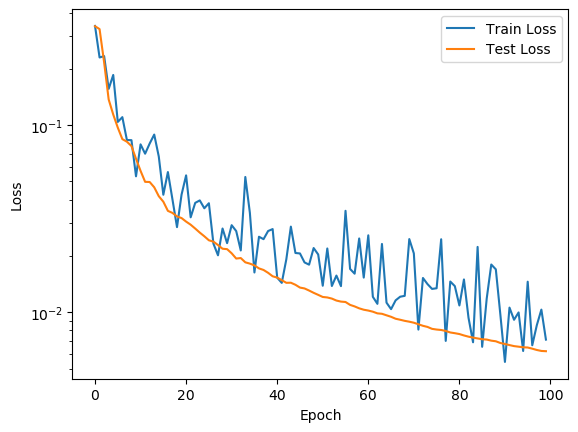

In [23]:

# plot (semilog) the history of the loss on the training and testing data subsets vs iteration count.
plt.semilogy(loss_train, label='Train Loss')
plt.semilogy(loss_test, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Confusion Matrix:
[[ 8  0]
 [ 0 12]]


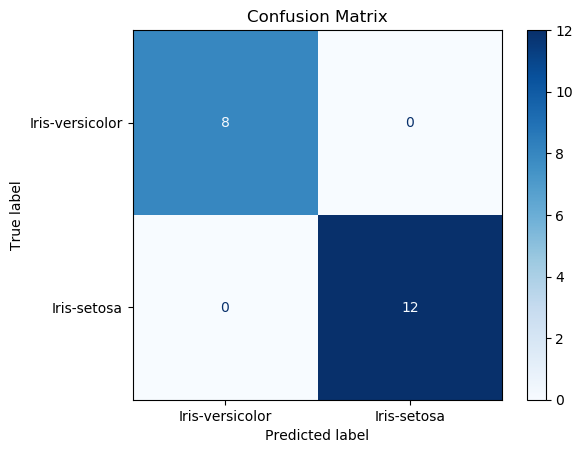

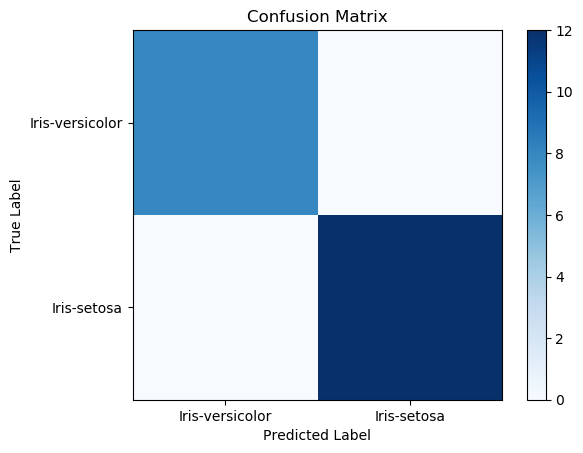

In [26]:
# generate a confusion matrix on the test set
y_pred = torch.sigmoid(torch.matmul(X_test, w)) >= 0.5

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# plot the map of the confusion matrix
# you can use sklearn's ConfusionMatrixDisplay or do it manually
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Iris-versicolor', 'Iris-setosa'])
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
plt.show()
# or do it manually
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks([0, 1], ['Iris-versicolor', 'Iris-setosa'])
plt.yticks([0, 1], ['Iris-versicolor', 'Iris-setosa'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()